/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


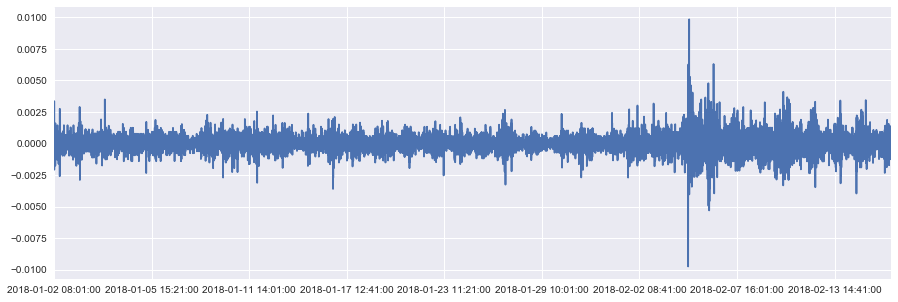

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

import networkx as nx
from statsmodels.tsa.stattools import adfuller

# read the data
# data = pd.read_csv('closing_prices_cleaned.csv')
data = pd.read_csv('LogRtnCleaned', index_col=0)

plt.figure(figsize=(15,5))
data['BNP Paribas'].plot()

In [13]:
# Get returns / log_returns from pricing data
# rtn = data.pct_change()[1:]
rtn = data.pct_change()
log_rtn = np.log(rtn + 1)
price = np.exp(log_rtn.cumsum()) -1
rtn = rtn.iloc[1:]
log_rtn = log_rtn.iloc[1:]
price = price.iloc[1:]

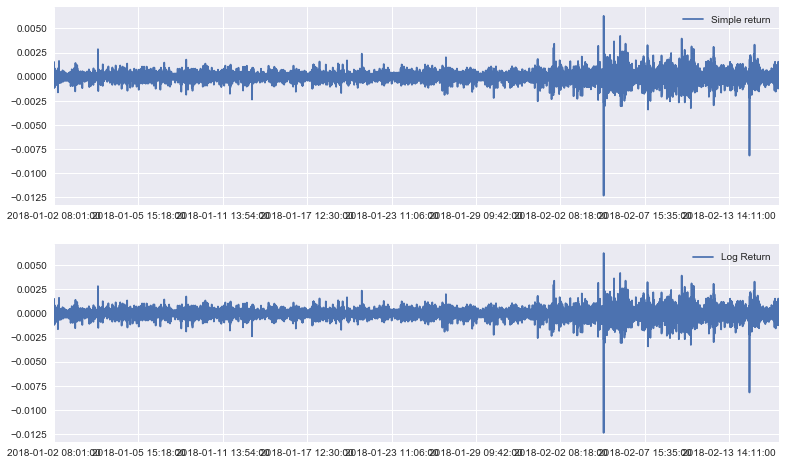

In [14]:
plt.figure(figsize=(13,8))
plt.subplot(211)
rtn['Total'].plot(label='Simple return', legend=True)
plt.subplot(212)
log_rtn['Total'].plot(label='Log Return', legend=True)

## Agumented Dick-Fuller test
Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be accepted or rejected. The result must be interpreted for a given problem to be meaningful.

Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [4]:
# remove the first entry cause it is NaN
resultLog = adfuller(log_rtn['Deutsche Bank'], regression='ctt')
resultData = adfuller(data['Deutsche Bank'], regression='ctt')

In [5]:
print('ADF Statistic (log-return): %f' % resultLog[0])
print('p-value (log-return): %f' % resultLog[1])
print('ADF Statistic: %f' % resultData[0])
print('p-value: %f' % resultData[1])
print('Critical Values:')
for key, value in resultData[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic (log-return): -79.300882
p-value (log-return): 0.000000
ADF Statistic: -1.711670
p-value: 0.905325
Critical Values:
	1%: -4.372
	5%: -3.833
	10%: -3.553


Accordingly to the ADF test, it looks like the original data isn't stationary, but log-returns are!! 
Somehow if I plot the autoregressive coeff for different legs I still see some time dependence. Is it normal?

Of course I'm expecting time dependency for the time series of prices, but the following ACF is a bit weird. I would have expected exponentially decaying time dependency... it is instead almost constant ~1

In [10]:
c = 'Bayern'
print('ADF Statistic ' + c + ' : %f' % resultLog[0])

ADF Statistic Bayern : -34.374815


In [11]:
for c in log_rtn.columns:
    resultLog = adfuller(log_rtn[c], regression='ctt')

    print('ADF Statistic ' + c + ' : %f' % resultLog[0])
'''    print('p-value (log-return): %f' % resultLog[1])
    print('Critical Values:')
    for key, value in resultLog[4].items():
        print('\t%s: %.3f' % (key, value))'''

ADF Statistic BNP Paribas : -22.612564
ADF Statistic Carrefour : -26.623769
ADF Statistic Cement Roadstone Hold : -23.000047
ADF Statistic Daimler : -22.241989
ADF Statistic Danone : -21.526065
ADF Statistic Deutsche Bank : -79.300882
ADF Statistic Deutsche Telekom : -20.449324
ADF Statistic ENEL : -44.094249
ADF Statistic Engie : -61.522389
ADF Statistic ENI : -23.558114
ADF Statistic EON : -24.730231
ADF Statistic Essilor Intl : -90.777114
ADF Statistic Iberdrola : -32.580198
ADF Statistic Industria Textil : -46.704754
ADF Statistic ING Group : -22.698043
ADF Statistic Intesa SP : -53.296897
ADF Statistic L’Oreal : -21.446562
ADF Statistic LVMH : -23.786017
ADF Statistic Munich RE : -22.922708
ADF Statistic Orange : -23.028451
ADF Statistic Philips : -21.741559
ADF Statistic Repsol : -21.112604
ADF Statistic RWE AG : -40.904323
ADF Statistic Saint Gobain : -29.152144
ADF Statistic Sanofi : -46.789031
ADF Statistic SAP : -20.462841
ADF Statistic Schneider : -23.018422
ADF Statistic Si

"    print('p-value (log-return): %f' % resultLog[1])\n    print('Critical Values:')\n    for key, value in resultLog[4].items():\n        print('\t%s: %.3f' % (key, value))"

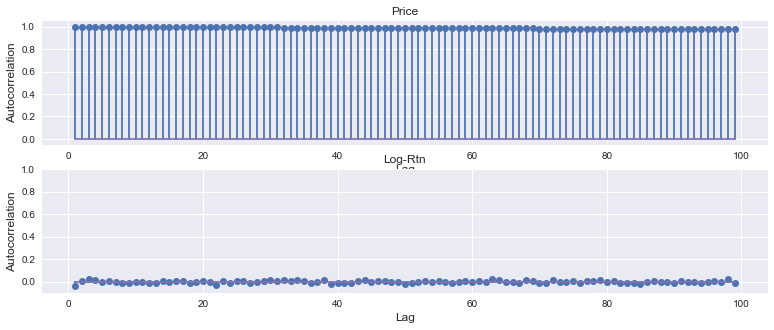

In [54]:
lags = range(1, 100)
autocorrs = [log_rtn['BBVA'].autocorr(lag=lag) 
                   for lag in lags]
autocorrsData = [data['BBVA'].autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(13, 5))
plt.subplot(211)
plt.stem(lags, autocorrsData)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.title('Price')
plt.subplot(212)
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.ylim([-.10,1])
plt.title('Log-Rtn')

Anywyay let's assume we have stationary data now... we can observe volatility clustering in the log_returns and we could remove that part too deploying a GARCH model... shall we???

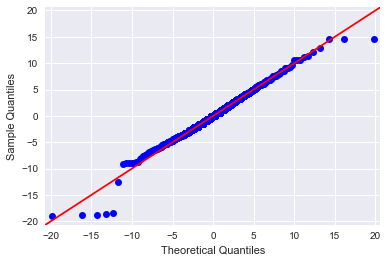

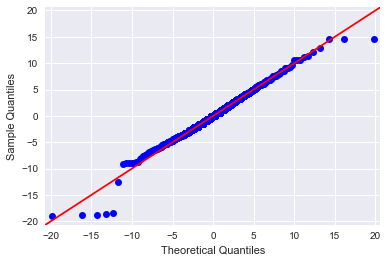

In [50]:
import statsmodels.api as sm
y = log_rtn['AXA']
sm.qqplot(y, line='45', dist=stats.t, fit=True)

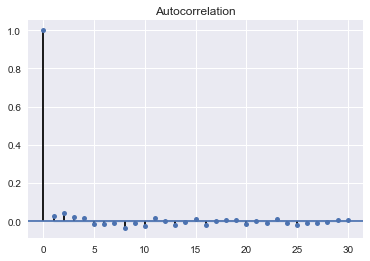

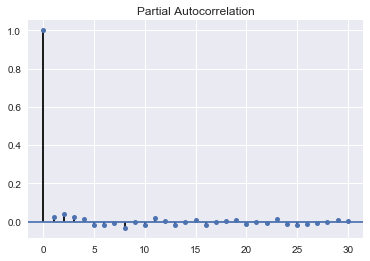

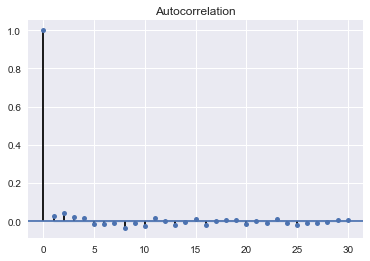

In [56]:
import statsmodels.tsa.api as smt
y = log_rtn['AXA']
plt.figure(figsize=(15,10))
smt.graphics.plot_pacf(y, lags=30, alpha=0.5)
smt.graphics.plot_acf(y, lags=30, alpha=0.5)

In [67]:
X = log_rtn[['BBVA','BNP Paribas']]
X

,BBVA,BNP Paribas
2018-01-02 08:01:00,-0.000140,-0.000638
2018-01-02 08:02:00,0.000420,-0.000639
2018-01-02 08:03:00,0.000000,-0.001759
2018-01-02 08:04:00,-0.001121,0.003355
2018-01-02 08:05:00,0.000561,-0.002076
2018-01-02 08:06:00,-0.000841,0.001278
2018-01-02 08:07:00,0.000000,-0.001438
2018-01-02 08:08:00,0.000421,-0.000160
2018-01-02 08:09:00,-0.000701,-0.000960
2018-01-02 08:10:00,-0.000421,0.000160


In [68]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(X, order=(5,1,0))
model_fit = model.fit(disp=0)

TypeError: must be str, not list

In [65]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.BBVA   No. Observations:                17191
Model:                 ARIMA(5, 1, 0)   Log Likelihood              101052.122
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 07 May 2018   AIC                        -202090.243
Time:                        19:06:26   BIC                        -202035.978
Sample:                    01-02-2018   HQIC                       -202072.359
                         - 02-15-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.564e-10   1.44e-06     -0.000      1.000   -2.83e-06    2.83e-06
ar.L1.D.BBVA    -0.8788      0.008   -116.781      0.000      -0.894      -0.864
ar.L2.D.BBVA    -0.7036      0.010    -72.078      0.000      -0.723      -0.685
ar.L3.D.BBVA    -0.5098      0.010    -48.830      0.000      -0.530      -0.489
ar.L4.D.BBVA    -0.3284      0.010    -33.646      0.000      -0.348      -0.309
ar.L5.D.BBVA    -0.1625      0.008    -21.598      0.000      -0.177      -0.148
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5379           -1.2880j            1.3958           -0.1870
AR.2            0.5379           +1.2880j            1.3958            0.1870
AR.3           -1.4854           -0.0000j            1.4854           -0.5000
AR.4           -0.8055           -1.2154j            1.4581           -0.3432
AR.5           -0.8055           +1.2154j            1.4581            0.3432
-----------------------------------------------------------------------------
"""

In [66]:
from arch import arch_model
#am = arch_model(log_rtn)

ModuleNotFoundError: No module named 'arch'

## VAR Model
With stationary data we can now make a VAR model

In [2]:
# make a VAR model
model = VAR(data)

In [135]:
?model.select_order()

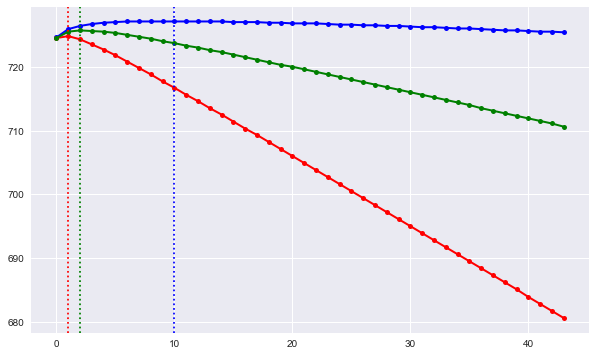

In [80]:
x = np.array ([
       [-724.6, -724.5, -724.5],
       [-725.9, -724.8, -725.5],
       [-726.4, -724.3, -725.7],
       [-726.7, -723.5, -725.6],
       [-726.9, -722.7, -725.5],
       [-727.0, -721.8, -725.3],
       [-727.1, -720.8, -725.0],
       [-727.1, -719.8, -724.7],
       [-727.1, -718.8, -724.4],
       [-727.1, -717.7, -724.0],
       [-727.1, -716.7, -723.7],
       [-727.1, -715.6, -723.3],
       [-727.1, -714.6, -723.0],
       [-727.1, -713.5, -722.6],
       [-727.1, -712.5, -722.3],
       [-727.0, -711.4, -721.9],
       [-727.0, -710.3, -721.5],
       [-727.0, -709.3, -721.1],
       [-726.9, -708.2, -720.7],
       [-726.9, -707.1, -720.3],
       [-726.8, -706.0, -720.0],
       [-726.8, -704.9, -719.6],
       [-726.8, -703.8, -719.2],
       [-726.7, -702.7, -718.8],
       [-726.6, -701.6, -718.4],
       [-726.6, -700.5, -718.0],
       [-726.5, -699.4, -717.6],
       [-726.5, -698.3, -717.2],
       [-726.4, -697.2, -716.8],
       [-726.4, -696.1, -716.4],
       [-726.3, -695.0, -716.0],
       [-726.2, -693.9, -715.6],
       [-726.2, -692.8, -715.2],
       [-726.1, -691.7, -714.8],
       [-726.0, -690.6, -714.4],
       [-726.0, -689.5, -714.0],
       [-725.9, -688.4, -713.5],
       [-725.8, -687.3, -713.1],
       [-725.7, -686.2, -712.7],
       [-725.7, -685.1, -712.3],
       [-725.6, -683.9, -711.9],
       [-725.5, -682.8, -711.5],
       [-725.5, -681.7, -711.1],
       [-725.4, -680.6, -710.6]])

plt.figure(figsize=(10,6))
plt.plot(-x[:,0], 'b-o', label='AIC', linewidth=2, markersize=5)
plt.plot(-x[:,1], 'r-o', label='BIC', linewidth=2, markersize=5)
plt.plot(-x[:,2], 'g-o', label='HQIC', linewidth=2, markersize=5)
plt.axvline(x=10, c='b', linestyle=':', label='best_AIC')
plt.axvline(x=1, c='r', linestyle=':', label='best_BIC')
plt.axvline(x=2, c='g', linestyle=':', label='best_HQIC')
#plt.grid(color='k', linestyle='-', linewidth=0.5, axis='y', alpha=0.3)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.legend(loc=8)
#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=2,
#           ncol=3, mode="expand", borderaxespad=0.)
#plt.legend(loc=7)
plt.savefig('IC.eps', format='eps', dpi=1000)
#plt.savefig('IC.pdf', format='pdf', transparent=True)

In [72]:
?plt.savefig()

In [3]:
VARresults = model.fit(maxlags=5, ic='bic')

In [4]:
VARresults.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 15, Jul, 2018
Time:                     10:03:59
--------------------------------------------------------------------
No. of Equations:         48.0000    BIC:                   -727.744
Nobs:                     17159.0    HQIC:                  -728.457
Log likelihood:       5.08647e+06    FPE:               3.04287e-317
AIC:                     -728.807    Det(Omega_mle):    2.65362e-317
--------------------------------------------------------------------
Results for equation BNP Paribas
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.000002         0.000005            0.343           0.731
L1.BNP Paribas                   0.005041         0.012674            0.398           0.691
L1.Carrefo

In [19]:
corrMat = pd.DataFrame(VARresults.resid_corr, columns=VARresults.names, index=VARresults.names)
corrMat

,BNP FP Equity,CA FP Equity,CRH ID Equity,DAI GR Equity,BN FP Equity,DBK GR Equity,DTE GR Equity,ENEL IM Equity,ENGI FP Equity,ENI IM Equity,...,ABI BB Equity,MTS SM Equity,ASML NA Equity,G IM Equity,CS FP Equity,BBVA SM Equity,SAN SM Equity,BAS GR Equity,BAYN GR Equity,BMW GR Equity
BNP FP Equity,1.000000,0.191964,0.217538,0.078031,0.290624,0.056676,0.045228,0.251964,0.324111,0.306225,...,0.309327,0.252592,0.256535,0.345088,0.557313,0.624628,0.637934,0.043920,0.061132,0.065204
CA FP Equity,0.191964,1.000000,0.158810,0.045596,0.222910,0.031738,0.044041,0.156563,0.214373,0.179048,...,0.197744,0.124690,0.180309,0.148454,0.233707,0.182233,0.184765,0.048437,0.055668,0.050561
CRH ID Equity,0.217538,0.158810,1.000000,0.024699,0.251658,0.019610,0.024759,0.181369,0.210604,0.196883,...,0.242124,0.187946,0.217295,0.157999,0.251155,0.213296,0.224680,0.004729,0.029476,0.029849
DAI GR Equity,0.078031,0.045596,0.024699,1.000000,0.059114,0.413669,0.423823,0.115991,0.061835,0.099392,...,0.133747,0.053738,0.093305,0.059208,0.065078,0.019809,0.028040,0.428089,0.599994,0.740655
BN FP Equity,0.290624,0.222910,0.251658,0.059114,1.000000,0.050055,0.034880,0.322886,0.423050,0.299447,...,0.515863,0.199458,0.331420,0.221796,0.395122,0.267411,0.268058,0.041758,0.062375,0.071663
DBK GR Equity,0.056676,0.031738,0.019610,0.413669,0.050055,1.000000,0.278978,0.046075,0.035745,0.069719,...,0.083205,0.023622,0.052167,0.038805,0.049050,0.019688,0.029611,0.319164,0.375741,0.403543
DTE GR Equity,0.045228,0.044041,0.024759,0.423823,0.034880,0.278978,1.000000,0.053089,0.036071,0.073936,...,0.082001,0.035264,0.061311,0.015609,0.046731,0.037182,0.036152,0.353431,0.395576,0.433574
ENEL IM Equity,0.251964,0.156563,0.181369,0.115991,0.322886,0.046075,0.053089,1.000000,0.402072,0.330293,...,0.324132,0.171761,0.262218,0.251335,0.291240,0.241670,0.251168,0.058122,0.089325,0.110473
ENGI FP Equity,0.324111,0.214373,0.210604,0.061835,0.423050,0.035745,0.036071,0.402072,1.000000,0.307414,...,0.368347,0.206146,0.278423,0.225360,0.370107,0.278128,0.283458,0.029549,0.055524,0.059964
ENI IM Equity,0.306225,0.179048,0.196883,0.099392,0.299447,0.069719,0.073936,0.330293,0.307414,1.000000,...,0.326381,0.255520,0.289210,0.285996,0.324542,0.283944,0.305559,0.035984,0.072083,0.098586


In [23]:
VARresults.resid.to_csv('VAR_Residuals_BIC_leg1')

In [163]:
# Transform it in a links data frame (3 columns only):
links = corrMat.stack().reset_index()
links.columns = ['var1', 'var2','value']
links

,var1,var2,value
0,BNP FP Equity,BNP FP Equity,1.000000
1,BNP FP Equity,CA FP Equity,0.191964
2,BNP FP Equity,CRH ID Equity,0.217538
3,BNP FP Equity,DAI GR Equity,0.078031
4,BNP FP Equity,BN FP Equity,0.290624
5,BNP FP Equity,DBK GR Equity,0.056676
6,BNP FP Equity,DTE GR Equity,0.045228
7,BNP FP Equity,ENEL IM Equity,0.251964
8,BNP FP Equity,ENGI FP Equity,0.324111
9,BNP FP Equity,ENI IM Equity,0.306225


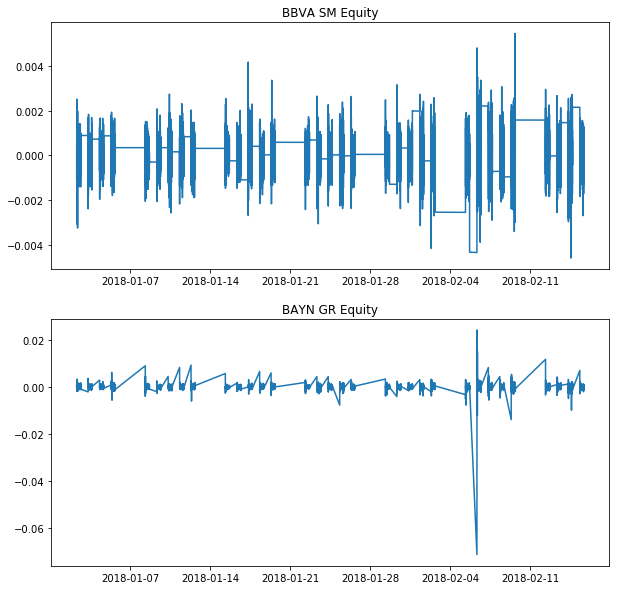

In [86]:
VARresults.plot()

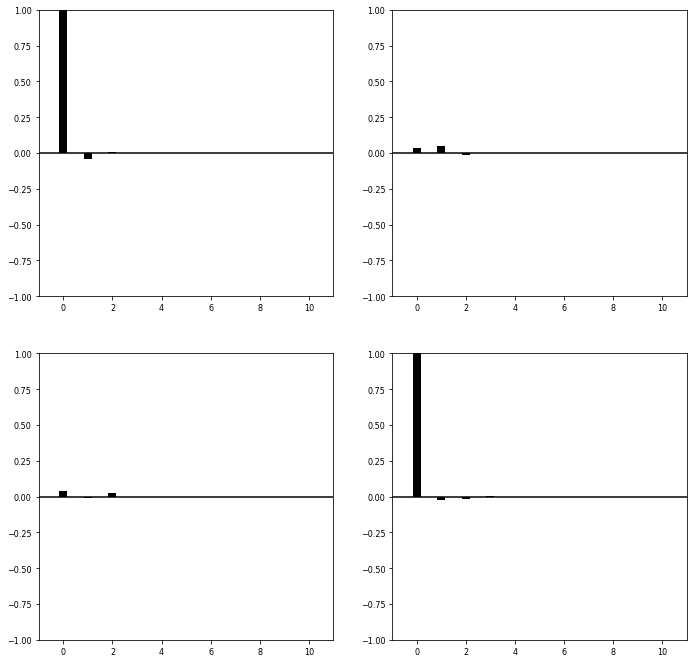

In [88]:
VARresults.plot_acorr()

In [5]:
VARresults.test_normality()

Normality skew/kurtosis Chi^2-test
    Test statistic   Critical Value          p-value  df
--------------------------------------------------------
  299301542.355611       119.870939            0.000  96
H_0: data generated by normally-distributed process
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 119.87093929856714,
 'df': 96,
 'pvalue': 0.0,
 'signif': 0.05,
 'statistic': 299301542.35561067}

FAIL: Some autocorrelations exceed 0.0153 bound. See plot


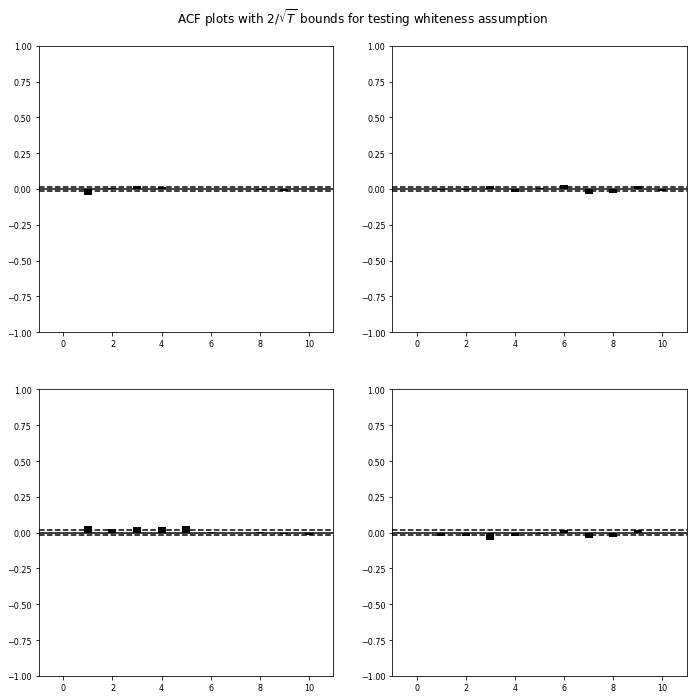

In [91]:
VARresults.test_whiteness()

In [93]:
VARresults.test_causality('BBVA SM Equity', 'BAYN GR Equity', kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value          df
---------------------------------------------------------------
         1.550436         2.995993            0.212  (2, 34368)
H_0: ['BAYN GR Equity'] do not Granger-cause BBVA SM Equity
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 2.995993415707408,
 'df': (2, 34368),
 'pvalue': 0.21217029667831247,
 'signif': 0.05,
 'statistic': 1.5504359808262878}

In [94]:
irf = VARresults.irf(10)

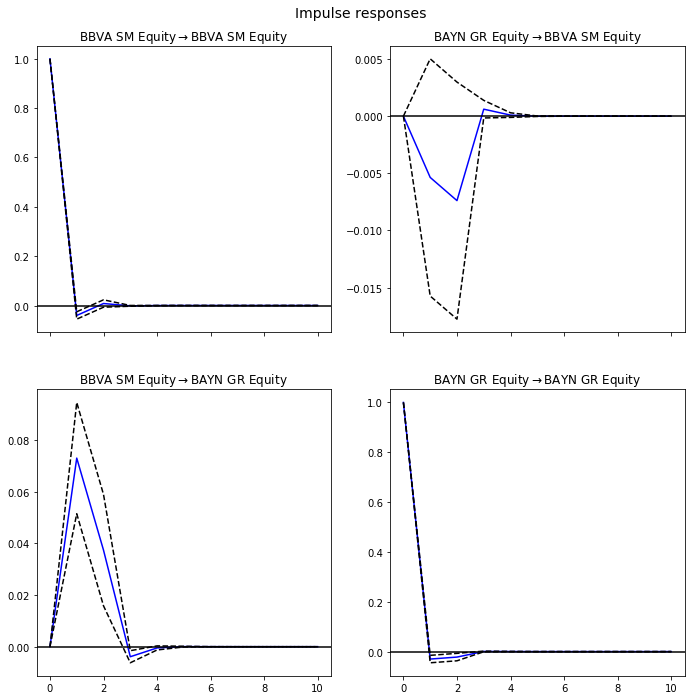

In [95]:
irf.plot(orth=False)

In [6]:
from statsmodels.api import tsa

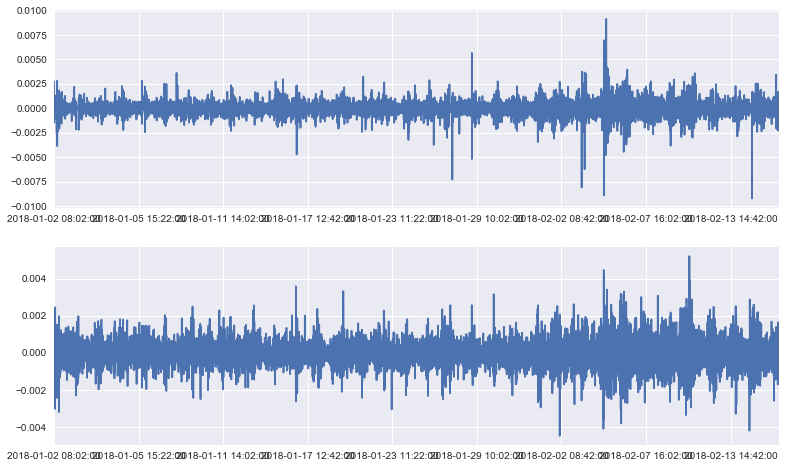

In [9]:
plt.figure(figsize=(13,8))
plt.subplot(211)
VARresults.resid['BMW'].plot()
plt.subplot(212)
VARresults.resid['BBVA'].plot()

In [124]:
resid = VARresults.resid['GLE FP Equity']

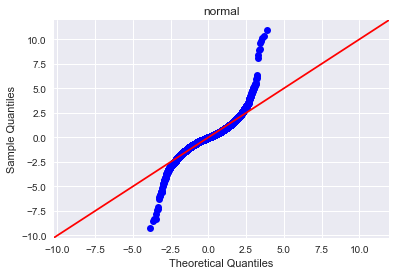

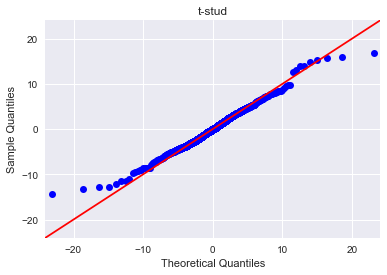

In [133]:
import statsmodels.api as sm
fig = sm.qqplot(resid, fit=True, line='45')
plt.title('normal')
fig = sm.qqplot(resid, stats.t, fit=True, line='45')
plt.title('t-stud')
#fig = sm.qqplot(resid, fit=True, line='45')
#fig = sm.qqplot(resid, stats.t, distargs=(4,))
#res = stats.probplot(resid, plot=plt)
#res = stats.q(resid, dist=stats.t(), plot=plt)
plt.show()

In [30]:
resid = VARresults.resid['BAYN GR Equity']
stats.normaltest(resid)

NormaltestResult(statistic=42981.824150222019, pvalue=0.0)

In [31]:
resid = VARresults.resid['BBVA SM Equity']
stats.normaltest(resid)

NormaltestResult(statistic=1732.8947582561464, pvalue=0.0)

(-0.005, 0.005)

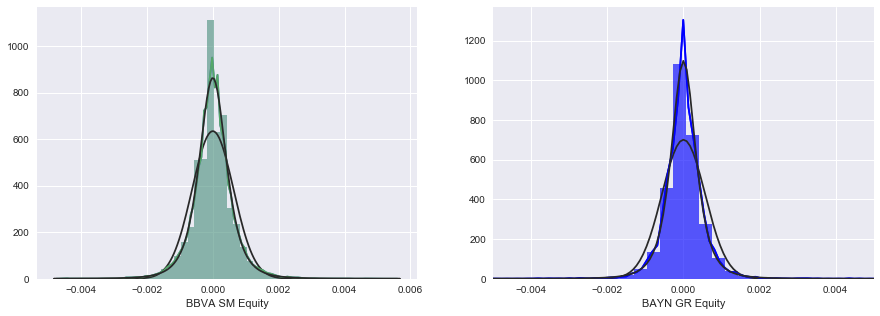

In [85]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(VARresults.resid['BBVA SM Equity'], kde=True, fit=stats.norm)
sns.distplot(VARresults.resid['BBVA SM Equity'], kde=True, fit=stats.t)
plt.subplot(122)
# only until 13000 to remove the extremes...
sns.distplot(VARresults.resid['BAYN GR Equity'][:13000], kde=True, fit=stats.norm, color='b')
sns.distplot(VARresults.resid['BAYN GR Equity'][:13000], kde=True, fit=stats.t, color='b')
plt.xlim([-.005, .005])

It looks like our residuals are distributed as a t-student!

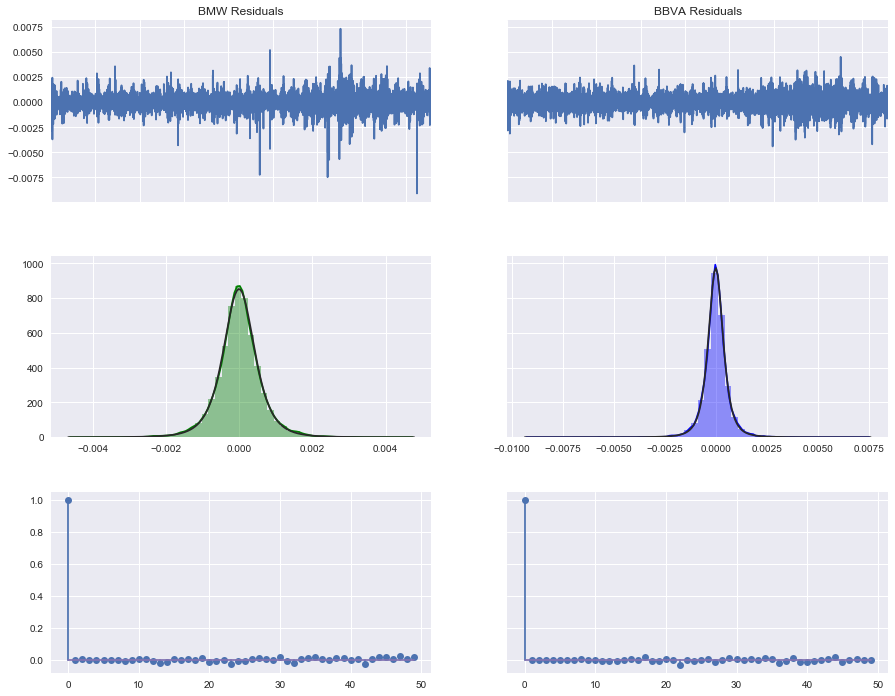

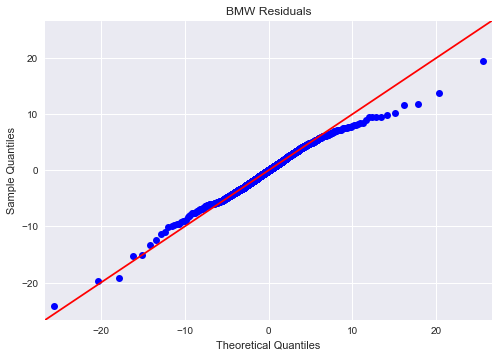

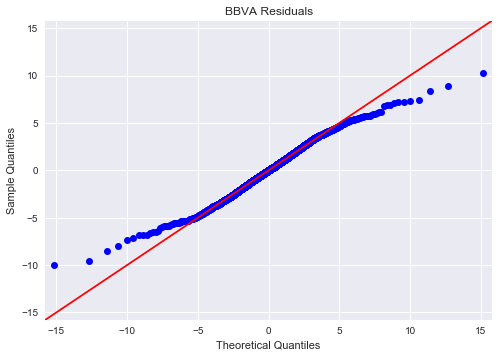

In [22]:

model = VAR(data)
res = model.fit(maxlags=9, ic='aic')
corrMat = pd.DataFrame(res.resid_corr, columns=res.names, index=res.names)

lags = range(0, 50)
acfBMW = [res.resid['BMW'].autocorr(lag=lag) 
          for lag in lags]
acfBBVA = [res.resid['BBVA'].autocorr(lag=lag) 
          for lag in lags]

plt.figure(figsize=(18, 6))
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharey='row')
#plt.subplot(321)
res.resid['BMW'].plot(ax=ax1)
#plt.plot(range(len(res.resid['BMW'])), res.resid['BMW'], sharey=ax1)
ax1.set_title('BMW Residuals')
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    labelbottom=False)

#plt.ylim([-0.01, 0.01])
#plt.subplot(322)
res.resid['BBVA'].plot(ax=ax2)
#plt.plot(range(len(res.resid['BMW'])), res.resid['BMW'], sharey=ax2)
ax2.set_title('BBVA Residuals')
ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    labelbottom=False)

#plt.subplot(323)
#sns.distplot(res.resid['BBVA'], kde=True, ax=ax3, fit=stats.norm, color='g')
sns.distplot(res.resid['BBVA'], kde=True, ax=ax3, fit=stats.t, color='g')
ax3.set_xlabel('')

#plt.subplot(324)
#sns.distplot(res.resid['BMW'], kde=True, ax=ax4, fit=stats.norm, color='b')
sns.distplot(res.resid['BMW'], kde=True, ax=ax4, fit=stats.t, color='b')
ax4.set_xlabel('')
#plt.xlim([-.005, .005])

#plt.subplot(325)
ax5.stem(lags, acfBMW)

#plt.subplot(326)
ax6.stem(lags, acfBBVA)
f.subplots_adjust(hspace=0.3, wspace=0.2)
f.set_figheight(12)
f.set_figwidth(15)
plt.savefig('BMW_BBVAfull.pdf', format='pdf')

fig = sm.qqplot(res.resid['BMW'], stats.t, fit=True, line='45')
plt.title('BMW Residuals')
plt.savefig('qqplotNormalBMWfull.eps', format='eps', dpi=1000)

fig = sm.qqplot(res.resid['BBVA'], stats.t, fit=True, line='45')
plt.title('BBVA Residuals')
plt.savefig('qqplotNormBBVAfull.eps', format='eps', dpi=1000)

#fig = sm.qqplot(resid, fit=True, line='45')
#fig = sm.qqplot(resid, stats.t, distargs=(4,))
#res = stats.probplot(resid, plot=plt)
#res = stats.q(resid, dist=stats.t(), plot=plt)
plt.show()

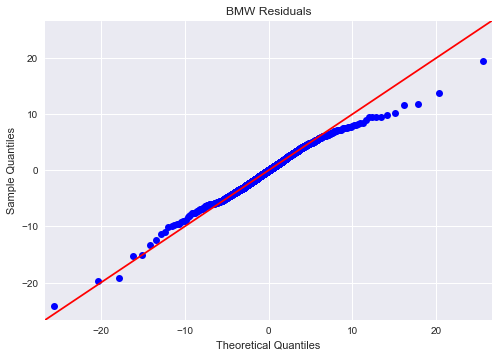

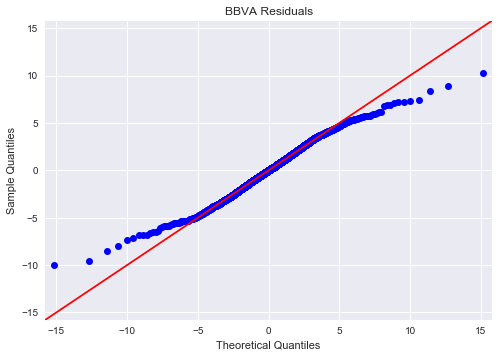

In [11]:
fig = sm.qqplot(res.resid['BMW'], stats.t, fit=True, line='45')
plt.title('BMW Residuals')
plt.savefig('qqplotNormalBMWfull.eps', format='eps', dpi=1000)

fig = sm.qqplot(res.resid['BBVA'], stats.t, fit=True, line='45')
plt.title('BBVA Residuals')
plt.savefig('qqplotNormBBVAfull.eps', format='eps', dpi=1000)

# Represent on a Graph

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


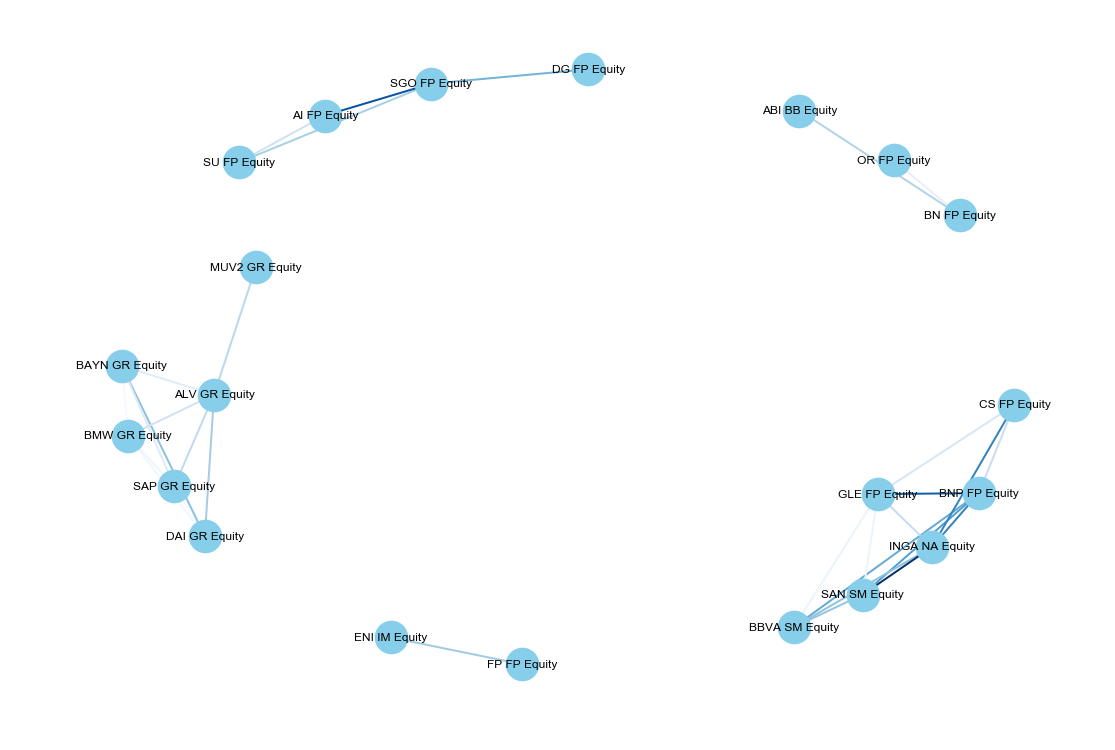

In [172]:
### Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] > 0.5) & (links['var1'] != links['var2']) ]
links_filtered

# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'var1', 'var2', create_using=nx.Graph() )

# Plot the network:
# if the graph is not directed you gotta need to drop duplicates in the edge_color cause
# links_filtered['value'] includes A->B and B->A while not directed graph cares only about 
# one between A->B or B->A
plt.figure(figsize=(15,10))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, linewidths=2, 
        font_size=12, edge_color=links_filtered['value'].drop_duplicates(), width=2.0, edge_cmap=plt.cm.Blues)

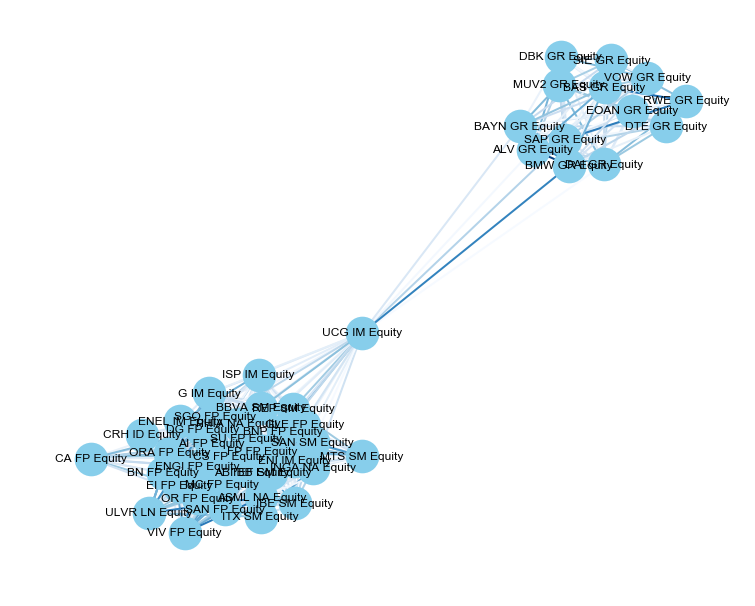

In [177]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def graph_plot(Threshold):
    plt.figure(figsize=(10,8))
    
    links_filtered=links.loc[ (links['value'] > Threshold) & (links['var1'] != links['var2']) ]
    links_filtered

    # Build your graph
    G=nx.from_pandas_dataframe(links_filtered, 'var1', 'var2', create_using=nx.Graph() )

    # Plot the network:
    # if the graph is not directed you gotta need to drop duplicates in the edge_color cause
    # links_filtered['value'] includes A->B and B->A while not directed graph cares only about 
    # one between A->B or B->A
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, linewidths=2, 
            font_size=12, edge_color=links_filtered['value'].drop_duplicates(), width=2.0, edge_cmap=plt.cm.Blues)
    
    plt.legend();
    plt.show()

interact(graph_plot, Threshold=(-1.0, 1.0));

# Dynamic VAR


In [80]:
# make a VAR model
DynModel = DynamicVAR(log_rtn)

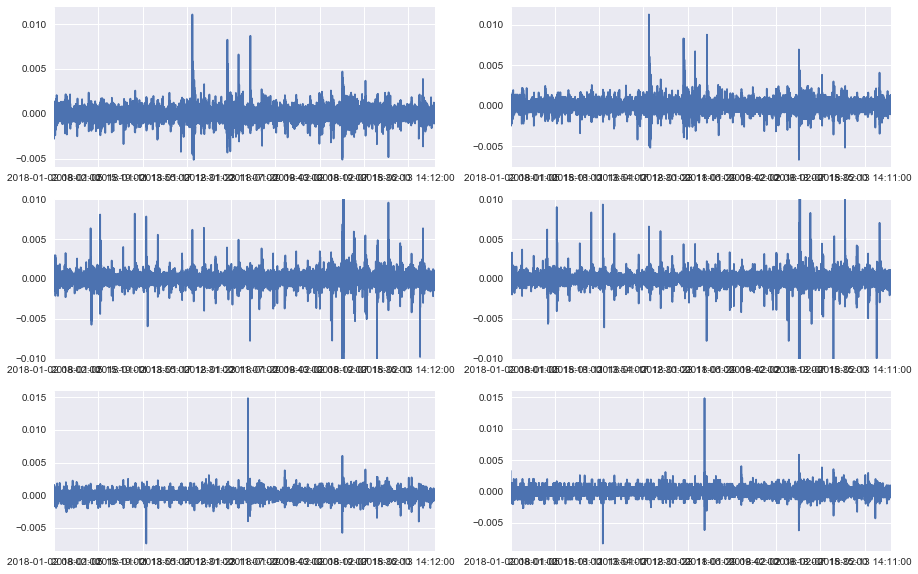

In [108]:
plt.figure(figsize=(15,10))
plt.subplot(321)
VARresults.resid['Carrefour'].plot()
plt.subplot(322)
log_rtn['Carrefour'].plot()
plt.subplot(323)
VARresults.resid['Bayer'].plot()
plt.ylim([-0.01, .01])
plt.subplot(324)
log_rtn['Bayer'].plot()
plt.ylim([-0.01, .01])
plt.subplot(325)
VARresults.resid['Generali'].plot()
plt.subplot(326)
log_rtn['Generali'].plot()

In [110]:
plt.figure(figsize=(15,5))
log_rtn['Bayer'].loc[1:1000].plot()

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [1] of <class 'int'>

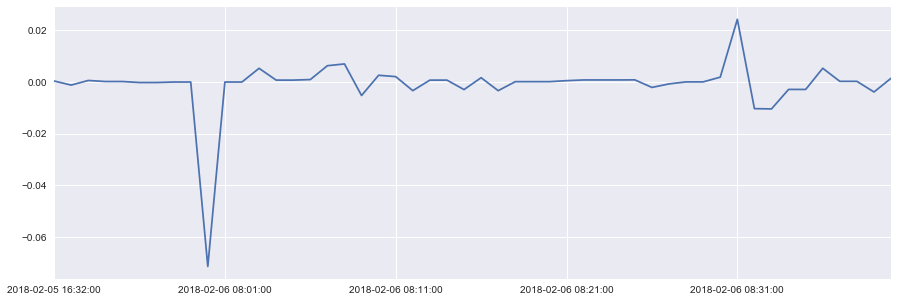

In [169]:
plt.figure(figsize=(15,5))
log_rtn['Bayer'][13015:13065].plot()

In [143]:
log_rtn['Bayer'][13015:13035].min()

-0.071429616522899059

In [159]:
for i in range(20):
    print(log_rtn['Bayer'][13015 + i])

0.000396039609137
-0.00118858968034
0.00059447143334
0.000198078637867
0.00019803941049
-0.00019803941049
-0.000198078637867
0.0
0.0
-0.0714296165229
0.0
0.0
0.00530505222969
0.000740466527724
0.000739918642711
0.000950520217312
0.00631381661804
0.00700363496235
-0.00522194398115
0.00261438057407


In [163]:
log_rtn['Bayer'][13024]

AttributeError: 'numpy.float64' object has no attribute 'loc'

In [167]:
log_rtn['Bayer'][13015:13030]

2018-02-05 16:32:00    0.000396
2018-02-05 16:33:00   -0.001189
2018-02-05 16:34:00    0.000594
2018-02-05 16:35:00    0.000198
2018-02-05 16:36:00    0.000198
2018-02-05 16:37:00   -0.000198
2018-02-05 16:38:00   -0.000198
2018-02-05 16:39:00    0.000000
2018-02-05 16:40:00    0.000000
2018-02-06 08:00:00   -0.071430
2018-02-06 08:01:00    0.000000
2018-02-06 08:02:00    0.000000
2018-02-06 08:03:00    0.005305
2018-02-06 08:04:00    0.000740
2018-02-06 08:05:00    0.000740
Name: Bayer, dtype: float64

In [172]:
data['Bayer'][13015:13060]

2018-02-05 16:31:00    100.980000
2018-02-05 16:32:00    101.020000
2018-02-05 16:33:00    100.900000
2018-02-05 16:34:00    100.960000
2018-02-05 16:35:00    100.980000
2018-02-05 16:36:00    101.000000
2018-02-05 16:37:00    100.980000
2018-02-05 16:38:00    100.960000
2018-02-05 16:39:00    100.960000
2018-02-05 16:40:00    100.960000
2018-02-06 08:00:00     94.000000
2018-02-06 08:01:00     94.000000
2018-02-06 08:02:00     94.000000
2018-02-06 08:03:00     94.500000
2018-02-06 08:04:00     94.570000
2018-02-06 08:05:00     94.640000
2018-02-06 08:06:00     94.730000
2018-02-06 08:07:00     95.330000
2018-02-06 08:08:00     96.000000
2018-02-06 08:09:00     95.500000
2018-02-06 08:10:00     95.750000
2018-02-06 08:11:00     95.950000
2018-02-06 08:12:00     95.630000
2018-02-06 08:13:00     95.700000
2018-02-06 08:14:00     95.770000
2018-02-06 08:15:00     95.490000
2018-02-06 08:16:00     95.650000
2018-02-06 08:17:00     95.330000
2018-02-06 08:18:00     95.343333
2018-02-06 08:

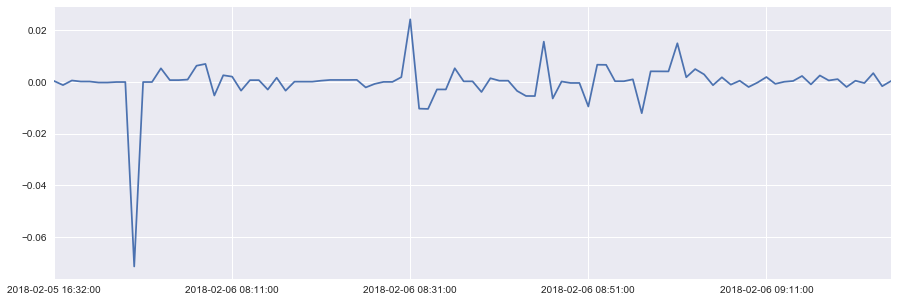

In [176]:
plt.figure(figsize=(15,5))
log_rtn['Bayer'][13015:13110].plot()